In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoModelForQuestionAnswering, AutoTokenizer
import os
import re
import string
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import extract_transform_evaluate_ds as docstrideFn
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_model(self, dataloader, optimizer, scheduler):
    self.train()
    accuracy_arr, loss_arr = [], []
    for batch in tqdm(dataloader, desc='Training Started!'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)
        start_pos = batch['start_positions'].to(self.device)
        end_pos = batch['end_positions'].to(self.device)
        start_res, end_res = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.find_focal_loss(start_res, end_res, start_pos, end_pos)
        loss_arr.append(loss.item())
        loss.backward()
        optimizer.step()

        start_pred = torch.argmax(start_res, dim=1)
        end_pred = torch.argmax(end_res, dim=1)

        accuracy_arr.append(((start_pred == start_pos).sum()/len(start_pred)).item())
        accuracy_arr.append(((end_pred == end_pos).sum()/len(end_pred)).item())
    scheduler.step()
    return sum(accuracy_arr)/len(accuracy_arr), sum(loss_arr)/len(loss_arr)

def plot_metrics(epochs, train_losses, train_accuracies, wer_scores, f1_scores):
    metrics = {
        'Training Loss': train_losses,
        'Training Accuracy': train_accuracies,
        'Word Error Rate (WER)': wer_scores,
        'F1 Score': f1_scores
    }

    colors = ['blue','green','red','brown']
    plt.figure(figsize=(12, 8))
    
    # Loop over metrics dictionary to create subplots
    for i, (title, values) in enumerate(metrics.items(), start=1):
        plt.subplot(2, 2, i)
        plt.plot(epochs, values, marker='o', linestyle='-', color=colors[i-1])
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(title.split()[1])
    
    plt.tight_layout()
    plt.show()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

Epoch - 1


Training Started!: 100%|██████████| 2320/2320 [12:24<00:00,  3.11it/s]


Train Accuracy: 0.7464555110910843 and Train Loss: 0.644321209718955


Evaluating Model!: 100%|██████████| 15875/15875 [03:24<00:00, 77.65it/s]


F1 Score: 0.8098273860818788 and WER Score: 0.4461021105826397
Epoch - 2


Training Started!: 100%|██████████| 2320/2320 [12:25<00:00,  3.11it/s]


Train Accuracy: 0.8459994612068965 and Train Loss: 0.30966219508153353


Evaluating Model!: 100%|██████████| 15875/15875 [03:24<00:00, 77.45it/s]


F1 Score: 0.8078702336620904 and WER Score: 0.4421819262782402
Epoch - 3


Training Started!: 100%|██████████| 2320/2320 [12:26<00:00,  3.11it/s]


Train Accuracy: 0.8985452586206897 and Train Loss: 0.17817066508056276


Evaluating Model!: 100%|██████████| 15875/15875 [03:24<00:00, 77.68it/s]


F1 Score: 0.8068152986335437 and WER Score: 0.4913978894173603
Epoch - 4


Training Started!: 100%|██████████| 2320/2320 [12:25<00:00,  3.11it/s]


Train Accuracy: 0.9362434575269962 and Train Loss: 0.10740432510170524


Evaluating Model!: 100%|██████████| 15875/15875 [03:24<00:00, 77.57it/s]


F1 Score: 0.8014941866064749 and WER Score: 0.4896328775267539
Epoch - 5


Training Started!: 100%|██████████| 2320/2320 [12:26<00:00,  3.11it/s]


Train Accuracy: 0.9528382851132031 and Train Loss: 0.07676584324280125


Evaluating Model!: 100%|██████████| 15875/15875 [03:24<00:00, 77.54it/s]


F1 Score: 0.788506012600644 and WER Score: 0.5132468787158145
Epoch - 6


Training Started!: 100%|██████████| 2320/2320 [12:25<00:00,  3.11it/s]


Train Accuracy: 0.9716998922413793 and Train Loss: 0.0456736687075418


Evaluating Model!: 100%|██████████| 15875/15875 [03:24<00:00, 77.63it/s]


F1 Score: 0.8010129905177374 and WER Score: 0.5249145362663495


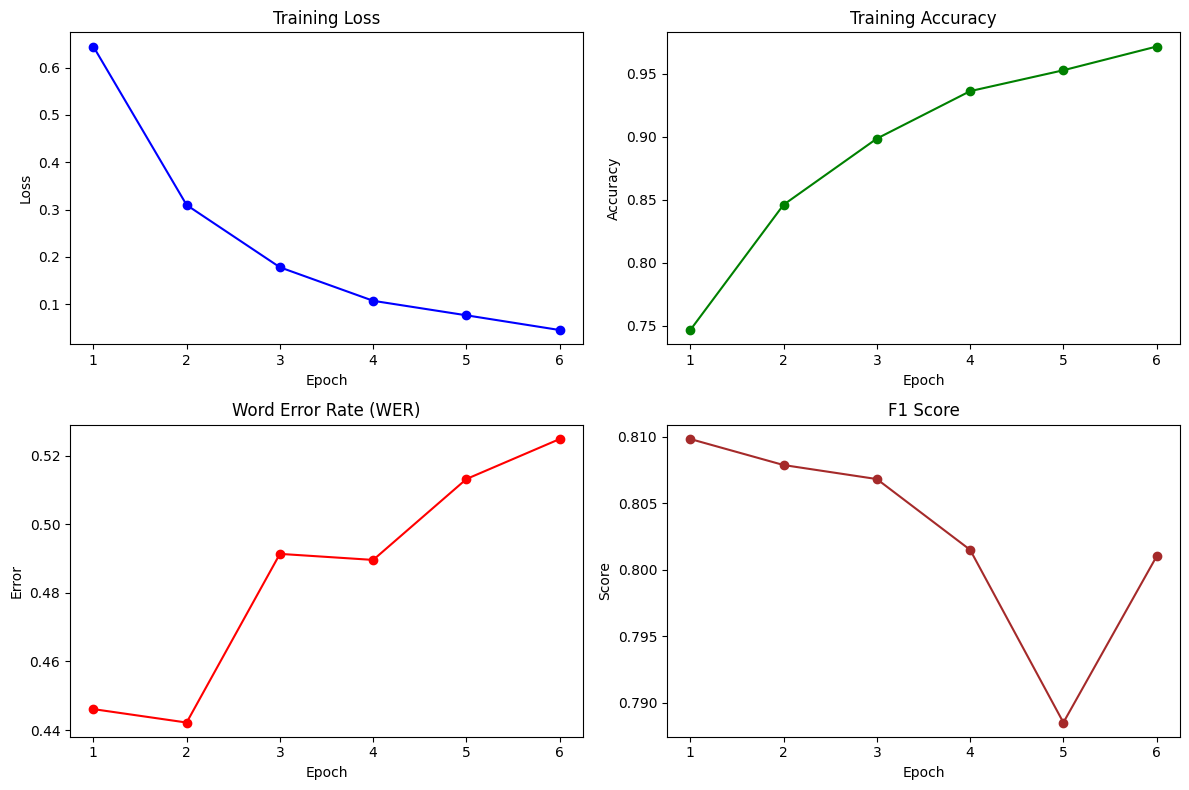

In [2]:
train_data = '../spoken_train-v1.1.json'
test_data = '../spoken_test-v1.1.json'
MODEL_PATH = "bert-large-uncased-whole-word-masking-finetuned-squad"
MODEL_SAVE_PATH = "qa_strong_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

train_encodings = docstrideFn.collect_and_find_positions(train_data, tokenizer, 512)
test_encodings = docstrideFn.collect_and_find_positions(test_data, tokenizer, 512)

train_set = docstrideFn.SpokenSquad(train_encodings)
test_set = docstrideFn.SpokenSquad(test_encodings)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1)

bert_large_uncased_model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)
qa_model = docstrideFn.QAModel(bert_large_uncased_model, device)
optimizer = AdamW(qa_model.parameters(), lr=2e-5, weight_decay=0.02)
scheduler = ExponentialLR(optimizer, gamma=0.9)

wer_scores, accuracies, losses, f1_scores  = [], [], [], []

epoch = 0
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

while epoch < 6:
    print(f'Epoch - {epoch + 1}')
    
    accuracy, loss = train_model(qa_model, train_loader, optimizer, scheduler)
    accuracies.append(accuracy)
    losses.append(loss)
    print(f"Train Accuracy: {accuracy} and Train Loss: {loss}")

    avg_f1_score, wer_score = qa_model.evaluate_model(test_loader, tokenizer)
    f1_scores.append(avg_f1_score)
    wer_scores.append(wer_score)
    print(f"F1 Score: {avg_f1_score} and WER Score: {wer_score}")

    epoch += 1

torch.save(qa_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'model_weights.pt'))
tokenizer.save_pretrained(MODEL_SAVE_PATH)

plot_metrics(range(1, 7), losses, accuracies, wer_scores, f1_scores) 